# Unigram model of text generation

## Introduction

This R Jupyter notebooks explores a unigram model of text generation, which is a generative process that creates a bag-of-words for each document.

The number of tokens in a document $d$ is denoted by $N_d$ where $N_d \sim \text{Poisson}(\lambda)$. $\lambda$ is the mean of the Poisson distribution, i.e. the mean number of tokens in a document.

The probability of a single token $t_i$ appearing in a document is denoted $p(t_i)$ and $p(t_i)$ is drawn from a Dirichlet distribution.

The probability of a document with tokens $t$ is given by

$$
p(t) = \prod_{i=1}^{N_d} p(t_i).
$$

In [1]:
# Import the required libraries
library(MCMCpack)
library(MCMCvis)
library(rjags)

# Ensure the figures are easy to view in the notebook
options(repr.plot.width=10, repr.plot.height=6)

Loading required package: coda

Loading required package: MASS

##
## Markov Chain Monte Carlo Package (MCMCpack)

## Copyright (C) 2003-2021 Andrew D. Martin, Kevin M. Quinn, and Jong Hee Park

##
## Support provided by the U.S. National Science Foundation

## (Grants SES-0350646 and SES-0350613)
##

Linked to JAGS 4.3.0

Loaded modules: basemod,bugs



## Data generation assuming a unigram model

In [2]:
# Number of documents to generate
D <- 10

# Mean of the number of tokens per document
lambda_N <- 5

# Token distribution
N_tokens <- 5
p_token <- rdirichlet(1, rep(1,N_tokens))
p_token

0.007083096,0.2358844,0.3975235,0.3528289,0.006680049


In [3]:
# Matrix of token counts
M <- matrix(0, nrow=D ,ncol=N_tokens)

# Number of tokens in the document
n_tokens_in_doc <- rep(0, D)

# Walk through each document
for (d in 1:D) {
    
    # Number of tokens in the document
    n_tokens_in_doc[d] <- rpois(1, lambda_N)
    
    # Token counts in the document
    M[d,] <- rmultinom(1, n_tokens_in_doc[d], p_token)
}

In [4]:
M

0,0,2,2,0
0,0,2,0,0
0,1,0,1,0
0,0,0,1,0
0,0,0,1,0
0,0,2,0,0
1,1,2,2,0
0,0,1,2,0
0,1,2,2,0
0,0,1,1,0


## Bayesian inference assuming a unigram model

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 20
   Unobserved stochastic nodes: 2
   Total graph size: 31

Initializing model



Warning message in MCMCsummary(samp, round = 2):
"Rhat statistic cannot be calculated with one chain. NAs inserted."


,mean,sd,2.5%,50%,97.5%,Rhat,n.eff
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>
lambda_p,2.86,0.53,1.92,2.83,3.99,NA,20000
p[1],0.06,0.04,0.01,0.05,0.16,NA,20549
p[2],0.12,0.06,0.04,0.11,0.25,NA,20000
p[3],0.39,0.08,0.24,0.39,0.56,NA,17650
p[4],0.39,0.08,0.23,0.39,0.56,NA,20000
p[5],0.03,0.03,0.00,0.02,0.11,NA,20000


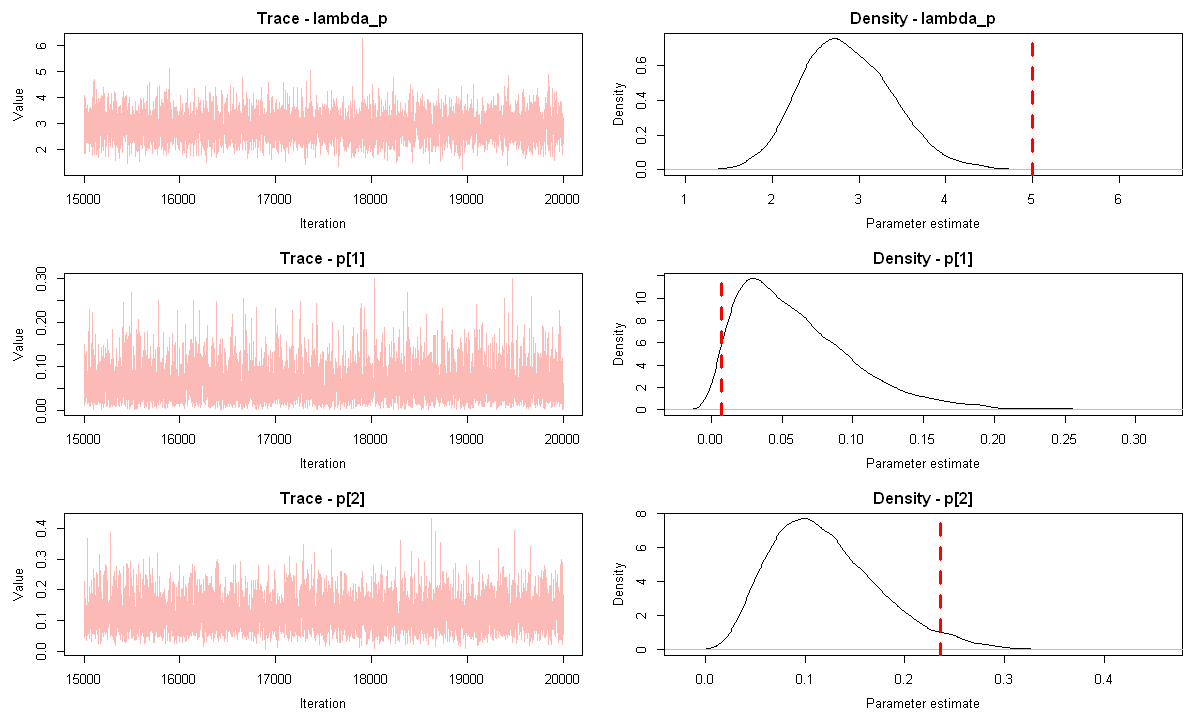

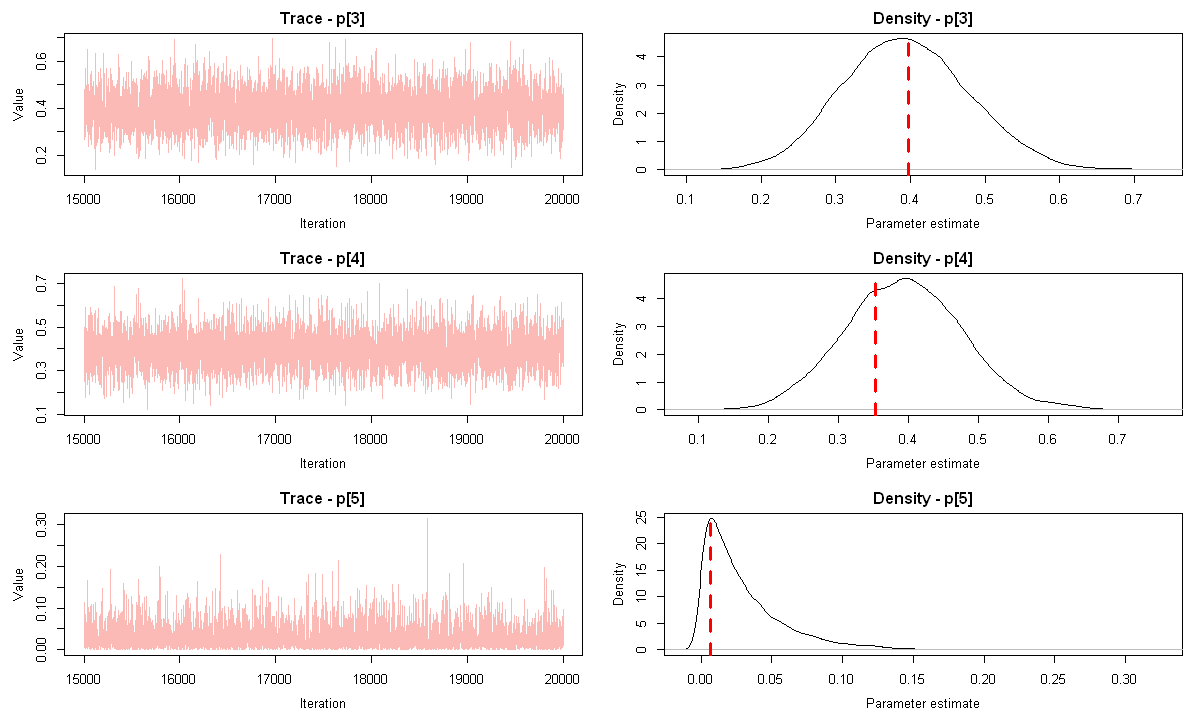

In [5]:
model_string = "
model {
    # Prior for the multinomial distribution of the token counts in a document
    p ~ ddirch(alpha)

    # Mean number of tokens in a document
    lambda_p ~ dgamma(1, 0.1)

    # Likelihood
    for (d in 1:D) {
        
        # Number of tokens in the document
        n[d] ~ dpois(lambda_p)

        # Token counts in the document
        M[d,] ~ dmulti(p, n[d])
    }
}
"

model = jags.model(textConnection(model_string),
                   data = list(alpha=rep(1,N_tokens), 
                               D=D,
                               n=n_tokens_in_doc, 
                               M=M))

update(model, 10000, progress.bar="none")

samp <- coda.samples(model, 
                     variable.names=c("p", "lambda_p"), 
                     n.iter=20000, progress.bar="none")

# Show a summary of the variables
MCMCsummary(samp, round = 2)

MCMCtrace(samp,
          gv=c(lambda_N, p_token),
          pdf=FALSE)

## Document allocation with two topics with labelled training data

In this section, two topics are considered, where each topic is generated using the unigram model and a document can only contain one topic. The training documents are labelled as to which topic they are derived from.  The problem is then to determine the topic to which an unlabelled document belongs. Thus, the problem is a classification problem posed as a Bayesian inference problem.

### Data generation

In [6]:
# Total number of (training) documents
N_D <- 10

# Number of distinct tokens in all documents
N_t <- 5

# Probability that the document is drawn from topic 1
p_topic1 <- 0.3

# Mean number of tokens in documents from topic 1
lambda1 <- 5

# Mean number of tokens in documents from topic 2
lambda2 <- 7

# Probability of tokens in topic 1
p_token1 <- rdirichlet(1, rep(1,N_tokens))

# Probability of tokens in topic 2
p_token2 <- rdirichlet(1, rep(1,N_tokens))

In [7]:
# Generate a random document
generate_document <- function() {

    # Topic from which the document was drawn
    topic <- rbinom(1, 1, p_topic1)
    
    # Number of tokens in the document
    if (topic == 0) {
        lambda <- lambda1
    } else {
        lambda <- lambda2
    }
    n_tokens_in_doc <- rpois(1, lambda)
    
    # Token counts in the document
    token_counts <- rmultinom(1, n_tokens_in_doc, p_token)
    
    # Return
    list(topic=topic,
         n_tokens_in_doc=n_tokens_in_doc, 
         token_counts=token_counts)
}

In [8]:
# Matrix of token counts
M <- matrix(0, nrow=N_D, ncol=N_t)

# Topic in the document
topic <- rep(0, N_D)

# Generate the training documents
for (d in 1:N_D) {
    
    doc <- generate_document()
    
    topic[d] <- doc$topic
    n_tokens_in_doc[d] <- doc$n_tokens_in_doc
    M[d,] <- doc$token_counts
}

In [9]:
# Generate the test document
doc_test <- generate_document()
doc_test$topic

[1] 0

### Bayesian inference using JAGS

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 22
   Unobserved stochastic nodes: 18
   Total graph size: 53

Initializing model



Warning message in MCMCsummary(samp, round = 2):
"Rhat statistic cannot be calculated with one chain. NAs inserted."


,mean,sd,2.5%,50%,97.5%,Rhat,n.eff
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>
lambda_p[1],6.26,0.79,4.81,6.22,7.89,NA,20000
lambda_p[2],8.00,2.70,3.74,7.66,14.08,NA,19183
p_topic,0.16,0.10,0.02,0.14,0.40,NA,16117
topic_test,0.12,0.32,0.00,0.00,1.00,NA,4595


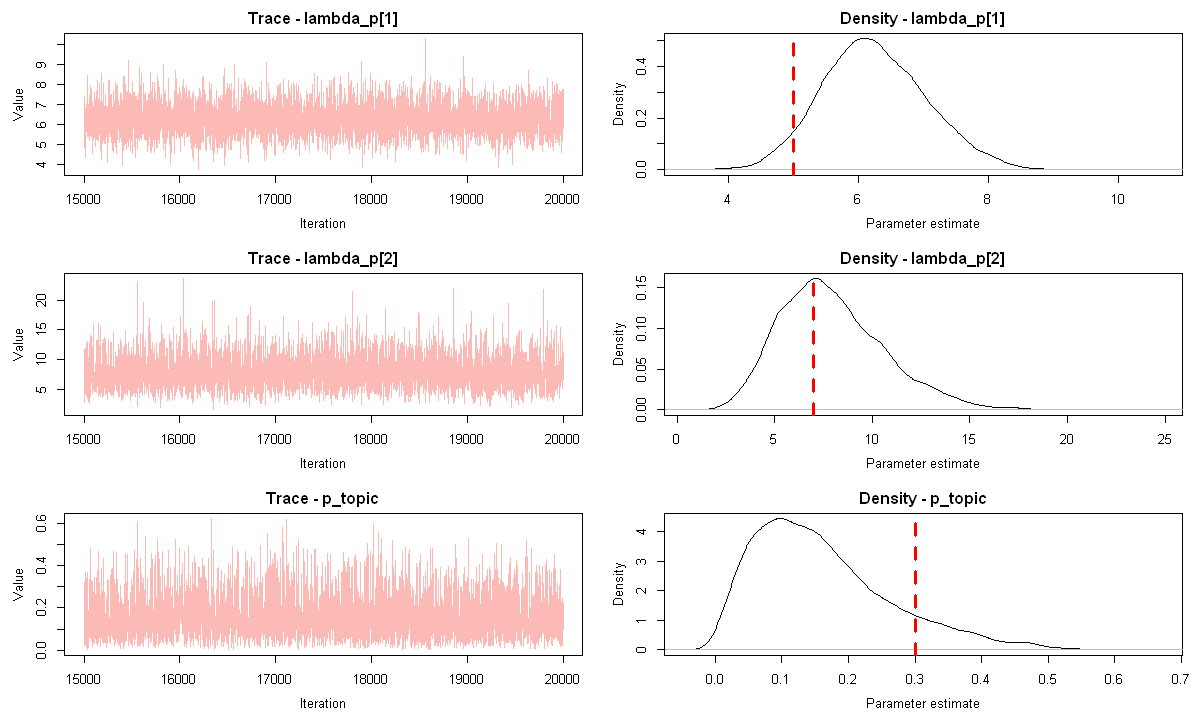

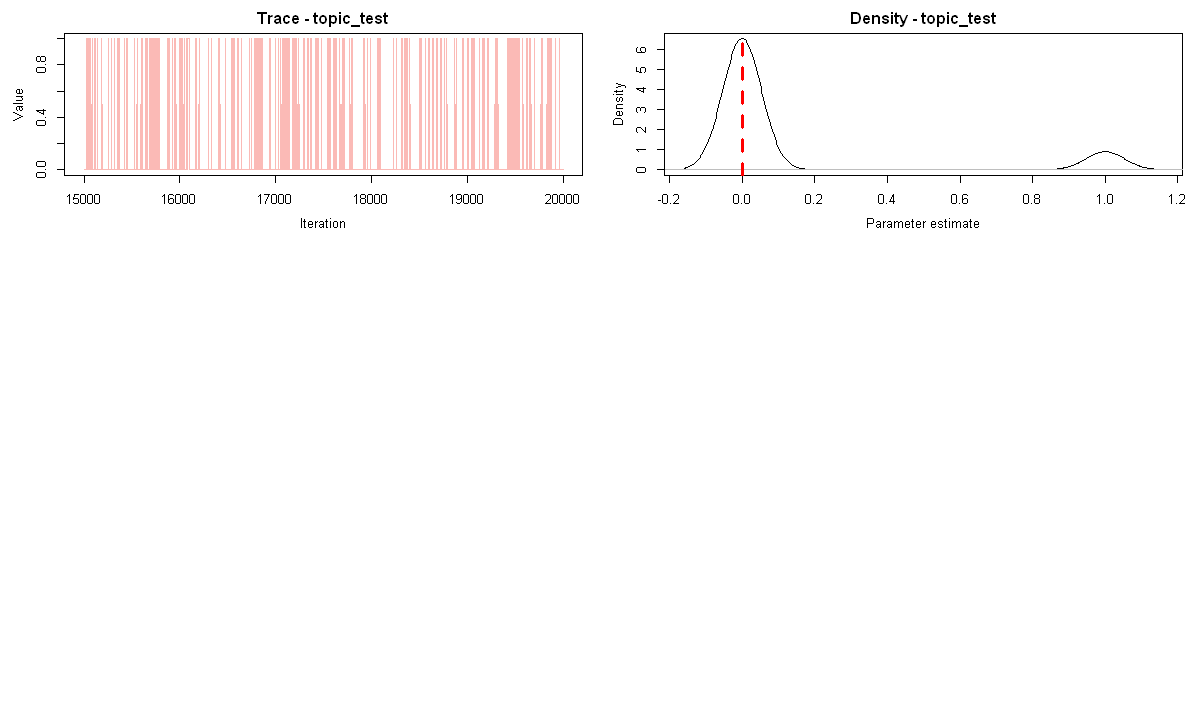

In [10]:
# Infer the parameters of the Bernoulli distribution using JAGS
model_string = "
model {
    # Prior for the multinomial distribution of the token counts in a document from each topic
    p[1, 1:N_tokens] ~ ddirch(alpha)
    p[2, 1:N_tokens] ~ ddirch(alpha)

    # Mean number of tokens in a document from each topic
    lambda_p[1] ~ dgamma(1, 0.1)
    lambda_p[2] ~ dgamma(1, 0.1)

    # Probability that a document is drawn from topic 1
    p_topic ~ dbeta(1, 1)

    # Mean number of tokens in a document from each topic
    lambda[1] ~ dgamma(1, 0.1)
    lambda[2] ~ dgamma(1, 0.1)

    # Likelihood
    for (d in 1:N_D) {
        
        # Topic from which the document was drawn
        topic[d] ~ dbern(p_topic)

        # Number of tokens in the document
        n[d] ~ dpois(lambda_p[topic[d] + 1])

        # Token counts in the document
        M[d, 1:N_tokens] ~ dmulti(p[topic[d]+1,1:N_tokens], n[d])
    }

    # Classify the test document
    topic_test ~ dbern(p_topic)
    n_test ~ dpois(lambda_p[topic_test + 1])
    counts_test ~ dmulti(p[topic_test+1, 1:N_tokens], n_test)
}
"

model = jags.model(textConnection(model_string),
                   data = list(N_tokens=N_tokens,
                               alpha=rep(1,N_tokens), 
                               N_D=N_D, 
                               topic=topic, 
                               n=n_tokens_in_doc, 
                               n_test=doc_test$n_tokens_in_doc, 
                               counts_test=doc_test$token_counts))

update(model, 10000, progress.bar="none")

samp <- coda.samples(model, 
                     variable.names=c("p_topic", "lambda_p", "topic_test"), 
                     n.iter=20000, 
                     progress.bar="none")

# Show a summary of the variables
MCMCsummary(samp, round = 2)

MCMCtrace(samp,
          gv=c(lambda1, lambda2, p_topic1, doc_test$topic),          
          pdf=FALSE)

In [11]:
# Probability that the test document belongs to topic 0
sum(as.matrix(samp)[,"topic_test"] == 0) / dim(as.matrix(samp))[1]

[1] 0.8837

This mixture of unigrams model (albeit with just two topics in the above example) is explored in more detail in another Jupyter notebook.